# License

***

J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Imports and Setup

***

In [1]:
import os
import time
import sys
import re
import subprocess

# in-notebook display
from IPython.display import Image
from IPython.display import display

import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

pd.options.display.max_columns = 999 # enable display of all columns in notebook

In [2]:
%matplotlib inline

In [3]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.112-b15, mixed mode)
  Starting server from C:\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\p\AppData\Local\Temp\tmpmyiecc0n
  JVM stdout: C:\Users\p\AppData\Local\Temp\tmpmyiecc0n\h2o_p_started_from_python.out
  JVM stderr: C:\Users\p\AppData\Local\Temp\tmpmyiecc0n\h2o_p_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.3
H2O cluster version age:,17 days
H2O cluster name:,H2O_from_python_p_aozzuw
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


#  Explore and prepare diabetes data

***

#### Import data

In [400]:
# import CSV file
train = pd.read_csv('data/diabetes_train.csv')
test = pd.read_csv('data/diabetes_test.csv')

In [401]:
train.head(n=10)

,id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
6,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,36900,77391171,AfricanAmerican,Male,[60-70),?,2,1,4,7,?,?,62,0,11,0,0,0,157,288,197,7,None,None,No,No,No,No,No,No,No,Up,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,<30
8,40926,85504905,Caucasian,Female,[40-50),?,1,3,7,7,?,Family/GeneralPractice,60,0,15,0,1,0,428,250.43,250.6,8,None,None,Steady,Up,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,<30
9,42570,77586282,Caucasian,Male,[80-90),?,1,6,7,10,?,Family/GeneralPractice,55,1,31,0,0,0,428,411,427,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO


In [402]:
for col in train.select_dtypes(include=['object']):
    n_levels = len(train[col].unique())
    if n_levels > 20:
        print(col + ' levels: ', train[col].unique())
        print()

medical_specialty levels:  ['Pediatrics-Endocrinology' '?' 'InternalMedicine' 'Family/GeneralPractice'
 'Cardiology' 'Surgery-General' 'Orthopedics' 'Gastroenterology'
 'Nephrology' 'Orthopedics-Reconstructive'
 'Surgery-Cardiovascular/Thoracic' 'Pulmonology' 'Psychiatry'
 'Emergency/Trauma' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Otolaryngology'
 'Surgery-Colon&Rectal' 'Urology' 'Psychiatry-Child/Adolescent'
 'Endocrinology' 'Neurology' 'Anesthesiology-Pediatric'
 'Pediatrics-CriticalCare' 'Radiology' 'Pediatrics-Hematology-Oncology'
 'Psychology' 'Hematology/Oncology' 'Podiatry' 'Gynecology' 'Oncology'
 'Pediatrics-Neurology' 'Surgery-Plastic' 'Surgery-Thoracic'
 'Surgery-Pediatric' 'Pediatrics-EmergencyMedicine'
 'PhysicalMedicineandRehabilitation' 'Pediatrics-Pulmonology'
 'Anesthesiology' 'Ophthalmology' 'InfectiousDiseases' 'Rheumatology'
 'AllergyandImmunology' 'Surgery-Maxillofacial' 'Surgeon'
 'Surgery-Vascular' 'Osteopat

In [403]:
def bin_less_common_levels(train, test, col_name, in_list):
    
    train.loc[~train[col_name].isin(in_list), col_name] = 'Other'
    test.loc[~test[col_name].isin(in_list), col_name] = 'Other'   
                                    
    print('Train levels:\n', train[col_name].value_counts())
    print()
    print('Test levels:\n', test[col_name].value_counts())

In [404]:
in_list = list(train['medical_specialty'].value_counts()[:10].index)
bin_less_common_levels(train, test, 'medical_specialty', in_list)

Train levels:
 ?                             20893
InternalMedicine               8899
Other                          5162
Family/GeneralPractice         4370
Cardiology                     3037
Emergency/Trauma               2824
Surgery-General                1649
Orthopedics-Reconstructive      898
Nephrology                      883
Orthopedics                     839
Psychiatry                      547
Name: medical_specialty, dtype: int64

Test levels:
 ?                             10841
Emergency/Trauma               1735
InternalMedicine               1013
Other                           974
Cardiology                      462
Family/GeneralPractice          407
Surgery-General                 404
Orthopedics                     234
Nephrology                       64
Psychiatry                       45
Orthopedics-Reconstructive       42
Name: medical_specialty, dtype: int64


In [405]:
in_list = list(train['diag_1'].value_counts()[:20].index)
bin_less_common_levels(train, test, 'diag_1', in_list)

Train levels:
 Other    25298
414       3464
428       2924
786       2071
410       1992
486       1662
427       1256
434       1103
715       1103
780        974
682        936
996        909
276        895
38         799
491        791
250.8      709
599        689
584        677
V57        651
820        590
518        508
Name: diag_1, dtype: int64

Test levels:
 Other    8061
414       993
428       849
410       557
427       536
786       527
715       480
486       477
491       411
434       337
38        335
682       332
584       319
780       315
599       289
996       287
276       281
250.8     269
518       240
820       195
V57       131
Name: diag_1, dtype: int64


In [406]:
in_list = list(train['diag_2'].value_counts()[:20].index)
bin_less_common_levels(train, test, 'diag_2', in_list)

Train levels:
 Other     20558
250        3425
276        3399
428        3233
427        2564
401        2094
496        1681
599        1570
403        1373
411        1358
414        1248
250.02     1060
250.01      944
707         879
780         794
285         667
682         646
518         641
425         639
491         630
424         598
Name: diag_2, dtype: int64

Test levels:
 Other     8346
250        966
276        961
428        750
427        643
401        607
599        555
414        503
285        350
518        311
707        302
411        285
496        283
250.02     255
491        217
682        210
425        199
780        171
403        164
424         88
250.01      55
Name: diag_2, dtype: int64


In [407]:
in_list = list(train['diag_3'].value_counts()[:20].index)
bin_less_common_levels(train, test, 'diag_3', in_list)

Train levels:
 Other     20338
250        6212
401        4473
276        2516
428        2102
427        1906
414        1701
496        1336
403        1023
272        1019
?           985
599         927
585         725
V45         686
780         662
707         640
250.02      631
285         558
250.01      541
424         522
250.6       498
Name: diag_3, dtype: int64

Test levels:
 Other     7415
250       1777
401       1331
276        868
414        612
428        603
427        545
585        412
272        388
403        347
599        319
496        270
285        228
250.02     220
780        207
707        191
V45        143
250.6      124
424        101
?          100
250.01      20
Name: diag_3, dtype: int64


In [408]:
for col in train.select_dtypes(include=['object']):
    n_levels = len(train[col].unique())
    print(col, n_levels)

race 6
gender 3
age 10
weight 9
payer_code 17
medical_specialty 11
diag_1 21
diag_2 21
diag_3 21
max_glu_serum 4
A1Cresult 4
metformin 4
repaglinide 4
nateglinide 4
chlorpropamide 4
glimepiride 4
acetohexamide 1
glipizide 4
glyburide 4
tolbutamide 2
pioglitazone 4
rosiglitazone 4
acarbose 4
miglitol 4
troglitazone 2
tolazamide 2
examide 1
citoglipton 1
insulin 4
glyburide-metformin 4
glipizide-metformin 2
glimepiride-pioglitazone 1
metformin-rosiglitazone 1
metformin-pioglitazone 1
change 2
diabetesMed 2
readmitted 2


In [409]:
drops = ['acetohexamide', 'examide', 'citoglipton', 'citoglipton', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']
target = 'readmitted'
encodes = list(set(train.select_dtypes(include=['object']).columns) - set(drops + [target]))

In [410]:
train = pd.concat([train.drop(encodes, axis=1),
                   pd.get_dummies(train[encodes])],
                   axis = 1)

test = pd.concat([test.drop(encodes, axis=1),
                  pd.get_dummies(test[encodes])],
                   axis = 1)

In [411]:
in_train_not_test = list(set(train.columns)-set(test.columns))
train.drop(in_train_not_test, axis=1, inplace=True)

in_test_not_train = list(set(test.columns)-set(train.columns))
test.drop(in_test_not_train, axis=1, inplace=True)

In [412]:
for name in train.columns:
    train.rename(columns={name: re.sub('[^0-9a-zA-Z]+', '_', name)}, inplace=True)
    test.rename(columns={name: re.sub('[^0-9a-zA-Z]+', '_', name)}, inplace=True)

In [413]:
print('All train and test columns match:', all(train.columns == test.columns))
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)

All train and test columns match: True
Train set shape: (50001, 201)
Test set shape: (16221, 201)


In [414]:
train.head()

,id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,acetohexamide,examide,citoglipton,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,readmitted,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,change_Ch,change_No,glipizide_metformin_No,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_,diag_3_Other,diag_3_V45,chlorpropamide_No,chlorpropamide_Steady,tolazamide_No,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,gender_Female,gender_Male,gender_Unknown_Invalid,tolbutamide_No,tolbutamide_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,miglitol_Down,miglitol_No,miglitol_Steady,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diabetesMed_No,diabetesMed_Yes,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,glyburide_metformin_No,glyburide_metformin_Steady,troglitazone_No,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,race_,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,medical_specialty_,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,weight_,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,payer_code_,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,acarbose_No,acarbose_Steady,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_
0,2278392,8222157,6,25,1,1,41,0,1,0,0,0,1,No,No,No,No,No,No,NO,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,64410,86047875,1,1,7,2,11,5,13,2,0,1,6,No,No,No,No,No,No,NO,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [415]:
test.head()

,id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,acetohexamide,examide,citoglipton,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,readmitted,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,change_Ch,change_No,glipizide_metformin_No,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_,diag_3_Other,diag_3_V45,chlorpropamide_No,chlorpropamide_Steady,tolazamide_No,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,gender_Female,gender_Male,gender_Unknown_Invalid,tolbutamide_No,tolbutamide_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,miglitol_Down,miglitol_No,miglitol_Steady,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diabetesMed_No,diabetesMed_Yes,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,glyburide_metformin_No,glyburide_metformin_Steady,troglitazone_No,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,race_,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,medical_specialty_,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,weight_,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,payer_code_,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,acarbose_No,acarbose_Steady,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_
0,240277404,34289775,1,1,7,1,50,6,25,0,0,0,9,No,No,No,No,No,No,NO,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,240282048,59363082,3,1,1,2,1,1,1,0,0,0,6,No,No,No,No,No,No,NO,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

#### Assign modeling roles

In [416]:
# assign target and inputs for GBM
y = 'readmitted'
drops = ['acetohexamide', 'examide', 'citoglipton', 'citoglipton', 'glimepiride_pioglitazone', 'metformin_rosiglitazone', 
         'metformin_pioglitazone']
X = [name for name in train.columns if name not in [target] + drops + ['id', 'patient_nbr']]
print('y =', y)
print('X =', X)

y = readmitted
X = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'glimepiride_Down', 'glimepiride_No', 'glimepiride_Steady', 'glimepiride_Up', 'change_Ch', 'change_No', 'glipizide_metformin_No', 'diag_3_250', 'diag_3_250_01', 'diag_3_250_02', 'diag_3_250_6', 'diag_3_272', 'diag_3_276', 'diag_3_285', 'diag_3_401', 'diag_3_403', 'diag_3_414', 'diag_3_424', 'diag_3_427', 'diag_3_428', 'diag_3_496', 'diag_3_585', 'diag_3_599', 'diag_3_707', 'diag_3_780', 'diag_3_', 'diag_3_Other', 'diag_3_V45', 'chlorpropamide_No', 'chlorpropamide_Steady', 'tolazamide_No', 'diag_1_250_8', 'diag_1_276', 'diag_1_38', 'diag_1_410', 'diag_1_414', 'diag_1_427', 'diag_1_428', 'diag_1_434', 'diag_1_486', 'diag_1_491', 'diag_1_518', 'diag_1_584', 'diag_1_599', 'diag_1_682', 'diag_1_715', 'diag_1_780', 'diag_1_786', 'diag_1_820', '

In [417]:
train[X] = train[X].apply(pd.to_numeric, errors='coerce', axis=1)
test[X] = test[X].apply(pd.to_numeric, errors='coerce', axis=1)

In [418]:
train.loc[train[y] == 'NO', y] = '0'
train.loc[train[y] != '0', y] = '1'
train[y] = train[y].apply(pd.to_numeric)

test.loc[test[y] == 'NO', y] = '0'
test.loc[test[y] != '0', y] = '1'
test[y] = test[y].apply(pd.to_numeric)

In [419]:
train[X + [y]].head()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,change_Ch,change_No,glipizide_metformin_No,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_,diag_3_Other,diag_3_V45,chlorpropamide_No,chlorpropamide_Steady,tolazamide_No,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,gender_Female,gender_Male,gender_Unknown_Invalid,tolbutamide_No,tolbutamide_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,miglitol_Down,miglitol_No,miglitol_Steady,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diabetesMed_No,diabetesMed_Yes,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,glyburide_metformin_No,glyburide_metformin_Steady,troglitazone_No,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,race_,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,medical_specialty_,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,weight_,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,payer_code_,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,acarbose_No,acarbose_Steady,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,readmitted
0,6.0,25.0,1.0,1.0,41.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.0,1.0,7.0,2.0,11.0,5.0,13.0,2.0,0.0,1.0,6.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0

In [420]:
test[X + [y]].head()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,change_Ch,change_No,glipizide_metformin_No,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_,diag_3_Other,diag_3_V45,chlorpropamide_No,chlorpropamide_Steady,tolazamide_No,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,gender_Female,gender_Male,gender_Unknown_Invalid,tolbutamide_No,tolbutamide_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,miglitol_Down,miglitol_No,miglitol_Steady,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diabetesMed_No,diabetesMed_Yes,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,glyburide_metformin_No,glyburide_metformin_Steady,troglitazone_No,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,race_,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,medical_specialty_,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,weight_,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,payer_code_,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,acarbose_No,acarbose_Steady,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,readmitted
0,1.0,1.0,7.0,1.0,50.0,6.0,25.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,3.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0

#### Display descriptive statistics

In [421]:
train[X + [y]].describe() # display descriptive statistics for all columns

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,change_Ch,change_No,glipizide_metformin_No,diag_3_250,diag_3_250_01,diag_3_250_02,diag_3_250_6,diag_3_272,diag_3_276,diag_3_285,diag_3_401,diag_3_403,diag_3_414,diag_3_424,diag_3_427,diag_3_428,diag_3_496,diag_3_585,diag_3_599,diag_3_707,diag_3_780,diag_3_,diag_3_Other,diag_3_V45,chlorpropamide_No,chlorpropamide_Steady,tolazamide_No,diag_1_250_8,diag_1_276,diag_1_38,diag_1_410,diag_1_414,diag_1_427,diag_1_428,diag_1_434,diag_1_486,diag_1_491,diag_1_518,diag_1_584,diag_1_599,diag_1_682,diag_1_715,diag_1_780,diag_1_786,diag_1_820,diag_1_996,diag_1_Other,diag_1_V57,gender_Female,gender_Male,gender_Unknown_Invalid,tolbutamide_No,tolbutamide_Steady,insulin_Down,insulin_No,insulin_Steady,insulin_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glipizide_Down,glipizide_No,glipizide_Steady,glipizide_Up,miglitol_Down,miglitol_No,miglitol_Steady,metformin_Down,metformin_No,metformin_Steady,metformin_Up,diabetesMed_No,diabetesMed_Yes,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,glyburide_metformin_No,glyburide_metformin_Steady,troglitazone_No,A1Cresult_7,A1Cresult_8,A1Cresult_None,A1Cresult_Norm,race_,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,diag_2_250,diag_2_250_01,diag_2_250_02,diag_2_276,diag_2_285,diag_2_401,diag_2_403,diag_2_411,diag_2_414,diag_2_424,diag_2_425,diag_2_427,diag_2_428,diag_2_491,diag_2_496,diag_2_518,diag_2_599,diag_2_682,diag_2_707,diag_2_780,diag_2_Other,medical_specialty_,medical_specialty_Cardiology,medical_specialty_Emergency_Trauma,medical_specialty_Family_GeneralPractice,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Orthopedics,medical_specialty_Orthopedics_Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Surgery_General,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,max_glu_serum_200,max_glu_serum_300,max_glu_serum_None,max_glu_serum_Norm,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,weight_,weight_0_25_,weight_100_125_,weight_125_150_,weight_150_175_,weight_175_200_,weight_25_50_,weight_50_75_,weight_75_100_,payer_code_,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,acarbose_No,acarbose_Steady,age_0_10_,age_10_20_,age_20_30_,age_30_40_,age_40_50_,age_50_60_,age_60_70_,age_70_80_,age_80_90_,age_90_100_,readmitted
count,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.00000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.00000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.00000,50001.00000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.00000,50001.000000,50001.000000,50001.000000,50001.000000,500

#### Calculate Pearson correlation

In [422]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(train[X + [y]].corr()[y]).iloc[:-1]

,readmitted
admission_type_id,-0.009461
discharge_disposition_id,0.037128
admission_source_id,0.016395
time_in_hospital,0.068106
num_lab_procedures,0.032412
num_procedures,-0.029204
num_medications,0.055739
number_outpatient,0.055808
number_emergency,0.121695
number_inpatient,0.268620


#### Create tuple of monotonicity constraints from Pearson correlation values

In [423]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(train[X + [y]].corr()[y].values[:-1])])
mono_constraints

(-1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1)

# Train XGBoost with monotonicity constraints

In [431]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

In [ ]:
"""
iter_ = 0 
best_error = 0
best_iter = 0
best_model = None
"""

In [432]:
"""
col_sample_rates = [0.1, 0.5, 0.9]
subsamples = [0.1, 0.5, 0.9]
etas = [0.01, 0.001]
max_depths = [3, 6, 12, 15, 18]
reg_alphas = [0.01, 0.001]
reg_lambdas = [0.01, 0.001]
ntrees = [200, 400]

total_models = len(col_sample_rates)*len(subsamples)*len(etas)*len(max_depths)*len(reg_alphas)*len(reg_lambdas)*len(ntrees)

# determine mean y value in training
y_mean = train[y].mean()

for col_sample_rate in col_sample_rates:
    for subsample in subsamples:
        for eta in etas:
            for max_depth in max_depths:
                for reg_alpha in reg_alphas:
                    for reg_lambda in reg_lambdas:
                        for ntree in ntrees:

                            tic = time.time()

                            print('---------- ---------')

                            print('Training model %d of %d ...' % (iter_ + 1, total_models))
                            print('col_sample_rate =', col_sample_rate)
                            print('subsample =', subsample)
                            print('eta =', eta)
                            print('max_depth =', max_depth)
                            print('reg_alpha =', reg_alpha)
                            print('reg_lambda =', reg_lambda)
                            print('ntree =', ntree)

                            params = {
                                 'base_score': y_mean,
                                 'booster': 'gbtree',
                                 'colsample_bytree': col_sample_rate,
                                 'eta': eta,
                                 'eval_metric': 'auc',
                                 'max_depth': max_depth,
                                 'nthread': 4,
                                 'objective': 'binary:logistic',
                                 'reg_alpha': reg_alpha,
                                 'reg_lambda': reg_lambda,
                                 'monotone_constraints': mono_constraints,
                                 'seed': 12345,
                                 'silent': 0,
                                 'subsample': subsample}

                            watchlist = [(dtrain, 'train'), (dtest, 'eval')]

                            model = xgb.train(
                                            params, 
                                            dtrain, 
                                            ntree,
                                            early_stopping_rounds=100,
                                            evals=watchlist, 
                                            verbose_eval=False)

                            print('Model %d trained in %.2f s.'  % (iter_, time.time()-tic))
                            print('Model %d best score = %.4f' % (iter_, model.best_score))

                            if model.best_score > best_error:
                                best_error = model.best_score
                                best_iter = iter_
                                best_model = model 
                                print('Best so far!!!')
                                print('Best error =', best_error)


                            iter_ += 1

print('Best model found at iteration: %d, with error: %d. % (best_iter, best_error))   

# col_sample_rate = 0.5
# subsample = 0.9
# eta = 0.01
# max_depth = 12
# reg_alpha = 0.01
# reg_lambda = 0.001
# ntree = 400

"""

---------- ---------
Training model 0 of 720 ...
col_sample_rate = 0.1
subsample = 0.1
eta = 0.01
max_depth = 3
reg_alpha = 0.01
reg_lambda = 0.01
ntree = 200
Model 0 trained in 7.36 s.
Model 0 best score = 0.7032
Best so far!!!
Best error = 0.703221
---------- ---------
Training model 1 of 720 ...
col_sample_rate = 0.1
subsample = 0.1
eta = 0.01
max_depth = 3
reg_alpha = 0.01
reg_lambda = 0.01
ntree = 400
Model 1 trained in 14.59 s.
Model 1 best score = 0.7037
Best so far!!!
Best error = 0.703723
---------- ---------
Training model 2 of 720 ...
col_sample_rate = 0.1
subsample = 0.1
eta = 0.01
max_depth = 3
reg_alpha = 0.01
reg_lambda = 0.001
ntree = 200
Model 2 trained in 6.24 s.
Model 2 best score = 0.7032
---------- ---------
Training model 3 of 720 ...
col_sample_rate = 0.1
subsample = 0.1
eta = 0.01
max_depth = 3
reg_alpha = 0.01
reg_lambda = 0.001
ntree = 400
Model 3 trained in 12.48 s.
Model 3 best score = 0.7037
Best so far!!!
Best error = 0.703725
---------- ---------
Training

# Global Variable Importance 

***

#### XGBoost variable importance

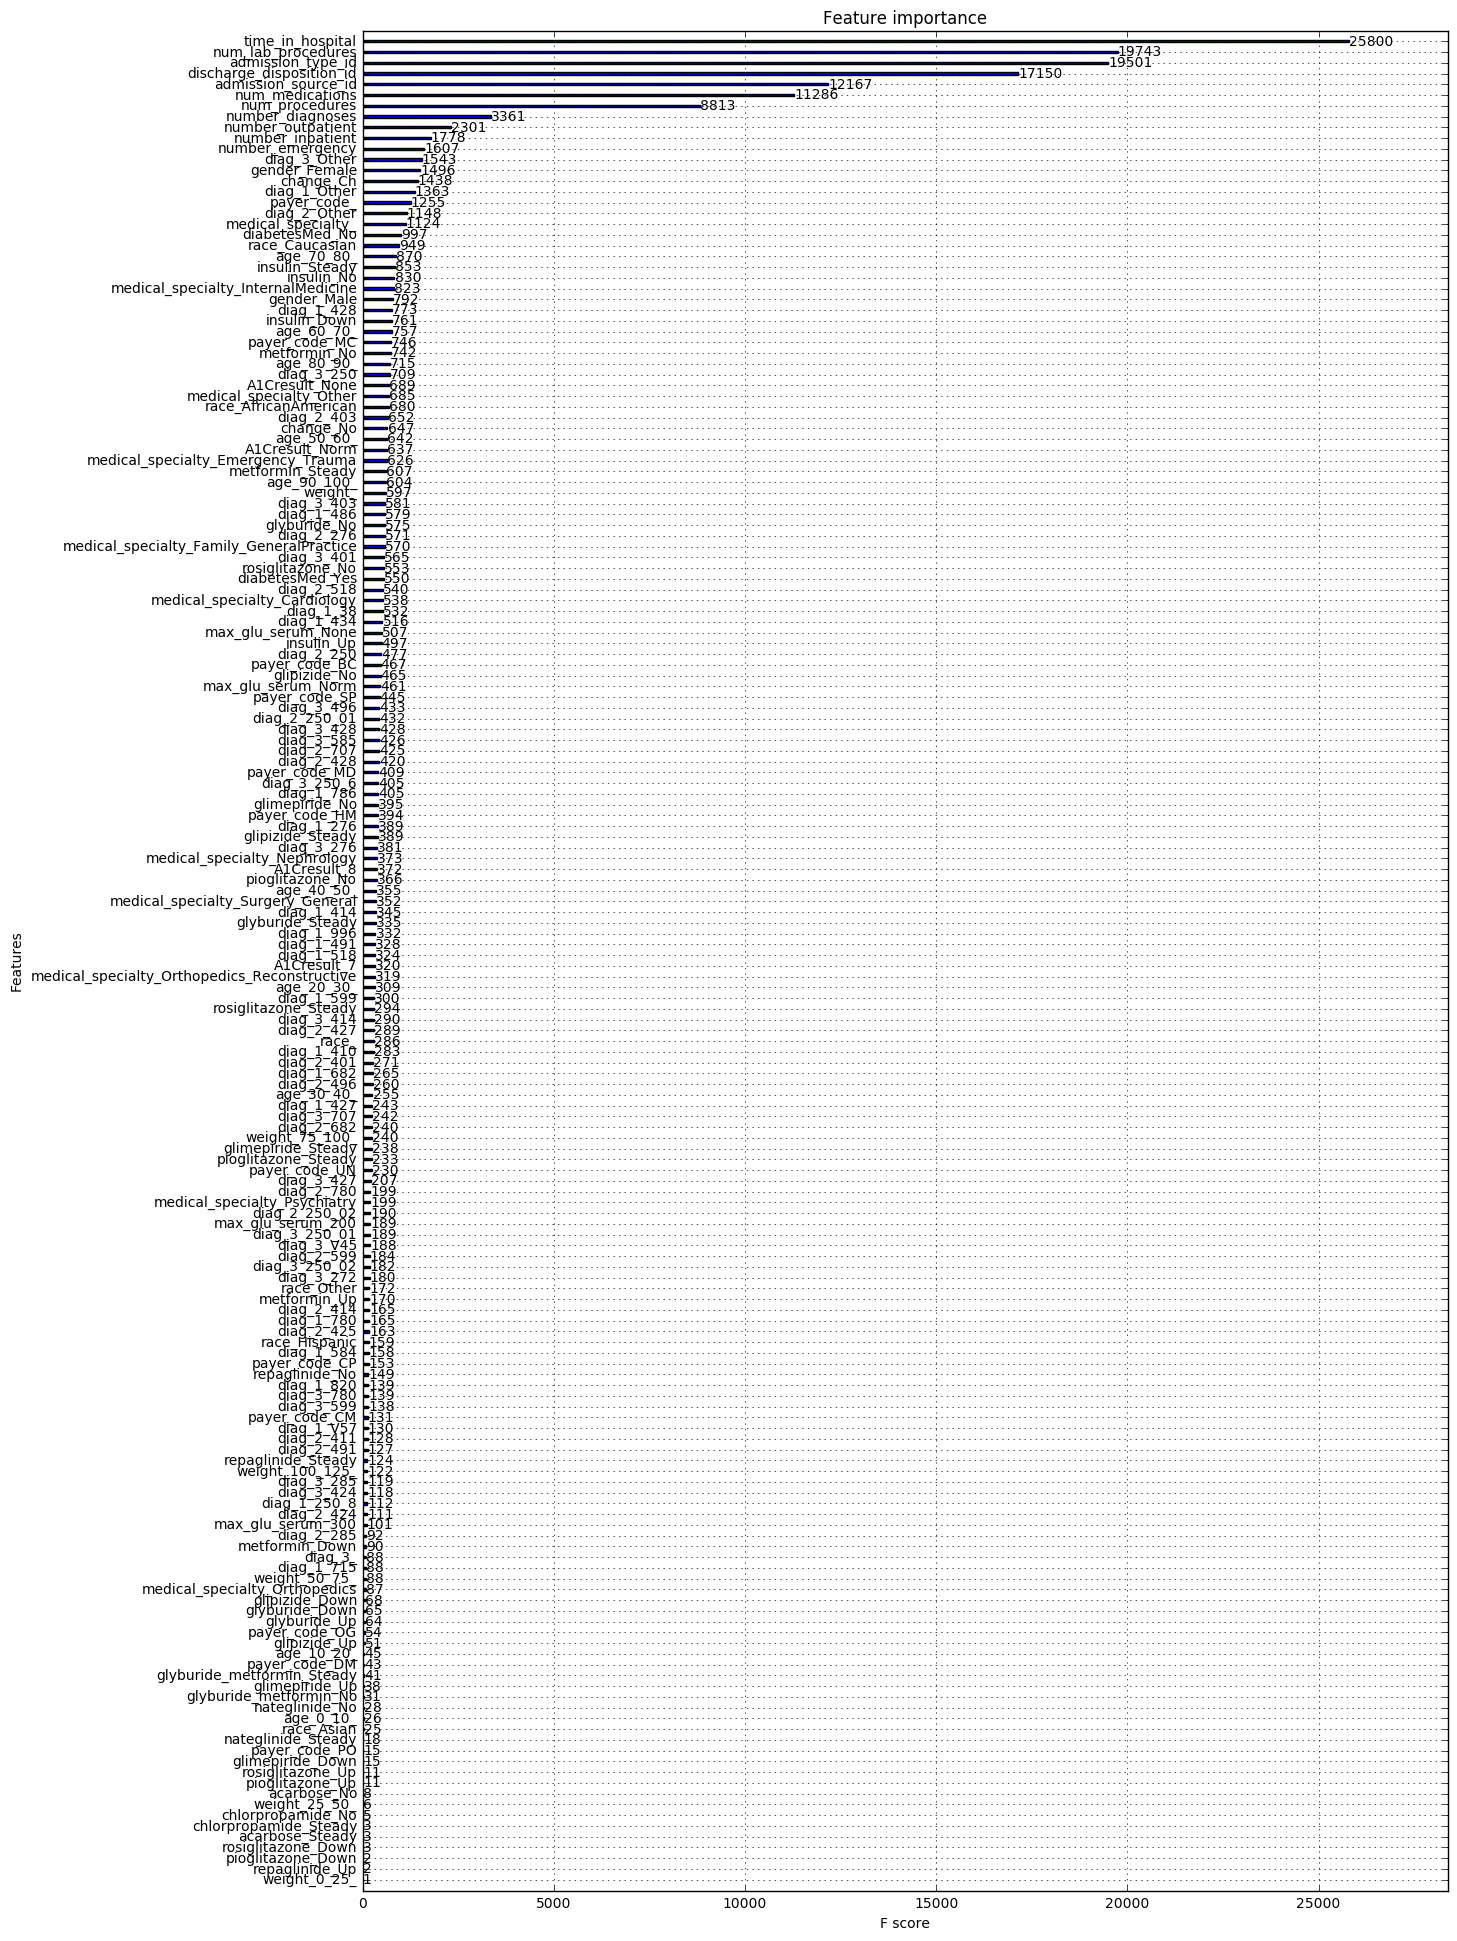

In [446]:
fig, ax = plt.subplots(figsize=(14, 24))
_ = plot_importance(best_model, ax=ax)

#### Eli5/Tree Interpreter variable importance

In [448]:
eli5.show_weights(best_model)

NameError: name 'eli5' is not defined

#### Shapley variable importance

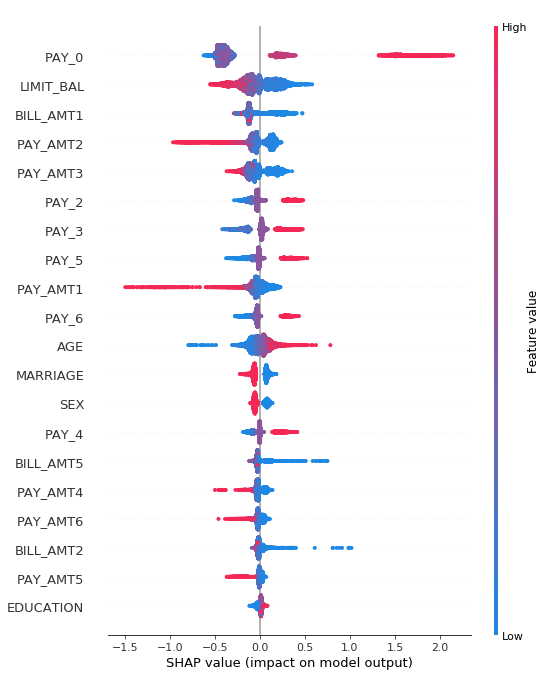

In [14]:
shap_values = best_model.predict(dtest, pred_contribs=True)
shap.summary_plot(shap_values, test[X])

#### Example Shapley dependence (you can try other variables)

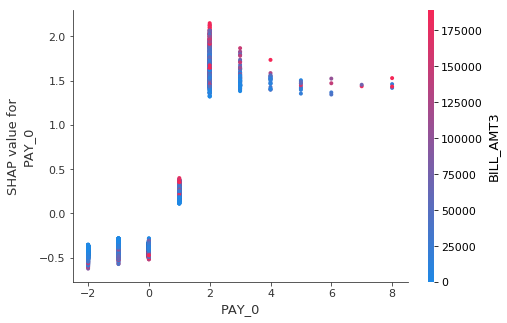

In [15]:
var = "PAY_0" 
shap.dependence_plot(var, shap_values, test[X])

#### Function for calculating partial dependence

In [16]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

#### Calculate partial dependence for the most important input variables in the GBM

In [17]:
par_dep_PAY_0 = par_dep('PAY_0', test[X], xgb_model)

In [18]:
par_dep_PAY_0

,PAY_0,partial_dependence
0,-2.0,0.164452
1,-1.5,0.174660
2,-1.0,0.174660
3,-0.5,0.175176
4,0.0,0.175179
5,0.5,0.260061
6,1.0,0.260061
7,1.5,0.555753
8,2.0,0.555753
9,2.5,0.555879


#### Bind XGBoost predictions to training data

In [19]:
xgb_preds = pd.DataFrame(xgb_model.predict(dtest))

In [20]:
test.reset_index(inplace=True)
test.drop(['index'], inplace=True, axis=1)

In [21]:
decile_frame = pd.concat([test, xgb_preds], axis=1)
decile_frame = decile_frame.rename(columns={0: 'predict'})
decile_hframe = h2o.H2OFrame(decile_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [22]:
decile_frame.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,predict
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,689,0,0,0,0,1,0.774720
1,7,500000,1,1,2,29,0,0,0,0,...,483003,473944,55000,40000,38000,20239,13750,13770,0,0.018403
2,9,140000,2,3,1,28,0,0,2,0,...,11793,3719,3329,0,432,1000,1000,1000,0,0.214771
3,11,200000,2,3,2,34,0,0,2,0,...,1828,3731,2306,12,50,300,3738,66,0,0.238153
4,12,260000,2,1,2,51,-1,-1,-1,-1,...,22287,13668,21818,9966,8583,22301,0,3640,0,0.067799


#### Find percentiles of XGBoost predictions

In [23]:
ds_ = DataMakerAndGetter()
percentile_dict = ds_.get_percentile_dict('predict', 'ID', decile_hframe)

In [24]:
percentile_dict

{0: 23477,
 10: 16339,
 20: 11924,
 30: 7711,
 40: 2941,
 50: 367,
 60: 21027,
 70: 14844,
 80: 15491,
 90: 27719,
 99: 17757}

#### Calculate ICE curve values

In [25]:
# retreive bins from original partial dependence calculation
bins_PAY_0 = list(par_dep_PAY_0['PAY_0'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for num11 across percentiles at bins_num11 intervals
    par_dep_PAY_0[col_name] = par_dep('PAY_0', 
                                      test[test['ID'] == int(percentile_dict[i])][X], 
                                      xgb_model, 
                                      bins=bins_PAY_0)['partial_dependence']


#### Display partial dependence and ICE for num9

In [26]:
par_dep_PAY_0

,PAY_0,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-2.0,0.164452,0.000981,0.050637,0.074242,0.094250,0.111219,0.140956,0.166176,0.236824,0.297155,0.146062,0.831526
1,-1.5,0.174660,0.001083,0.055663,0.079537,0.099942,0.124984,0.151967,0.183899,0.243173,0.325452,0.159660,0.849480
2,-1.0,0.174660,0.001083,0.055663,0.079537,0.099942,0.124984,0.151967,0.183899,0.243173,0.325452,0.159660,0.849480
3,-0.5,0.175176,0.001287,0.057499,0.079537,0.099942,0.124984,0.151967,0.183899,0.243173,0.325901,0.159660,0.854391
4,0.0,0.175179,0.001287,0.057499,0.079537,0.099942,0.124984,0.151967,0.183899,0.243173,0.325901,0.159660,0.854391
5,0.5,0.260061,0.003860,0.128749,0.172442,0.190945,0.194201,0.242888,0.278614,0.299842,0.458100,0.269978,0.907970
6,1.0,0.260061,0.003860,0.128749,0.172442,0.190945,0.194201,0.242888,0.278614,0.299842,0.458100,0.269978,0.907970
7,1.5,0.555753,0.028605,0.530701,0.541829,0.569588,0.496096,0.643140,0.690764,0.525924,0.730770,0.599291,0.971720
8,2.0,0.555753,0.028605,0.530701,0.541829,0.569588,0.496096,0.643140,0.690764,0.525924,0.730770,0.599291,0.971720
9,2.5,0.555879,0.028613,0.530815,0.542152,0.569588,0.496260,0.643140,0.690764,0.525924,0.730770,0.599532,0.972647


#### Plot partial dependence and ICE

In [27]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


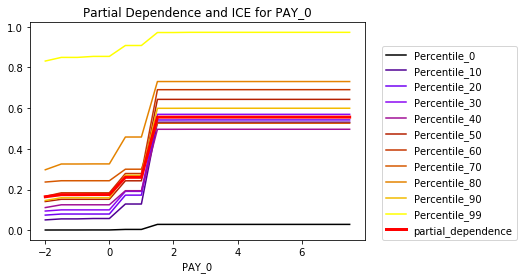

In [28]:
plot_par_dep_ICE('PAY_0', par_dep_PAY_0)

#### Train single h2o decision tree

In [29]:
model_id = 'dt_surrogate_mojo' # gives MOJO artifact a recognizable name

# initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                     sample_rate=1,     # use all rows in that tree
                                     mtries=-2,         # use all columns in that tree
                                     max_depth=3,       # shallow trees are easier to understand
                                     seed=12345,        # random seed for reproducibility
                                     model_id=model_id) # gives MOJO artifact a recognizable name

# train single tree surrogate model
surrogate.train(x=X, y='predict', training_frame=decile_hframe)

# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /home/patrickh/workspace/mli-resources/lime_shap_treeint_compare/dt_surrogate_mojo.zip


#### Create GraphViz dot file

In [30]:
# title for plot
title = 'Credit Card Data Decision Tree Surrogate'  

# locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

# construct command line call to generate graphviz version of 
# surrogate tree see for more information: 
# http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
# call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/workspace/mli-resources/lime_shap_treeint_compare/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Credit Card Data Decision Tree Surrogate


#### Create PNG from GraphViz dot file and display

In [31]:
# construct call to generate PNG from 
# graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

# call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


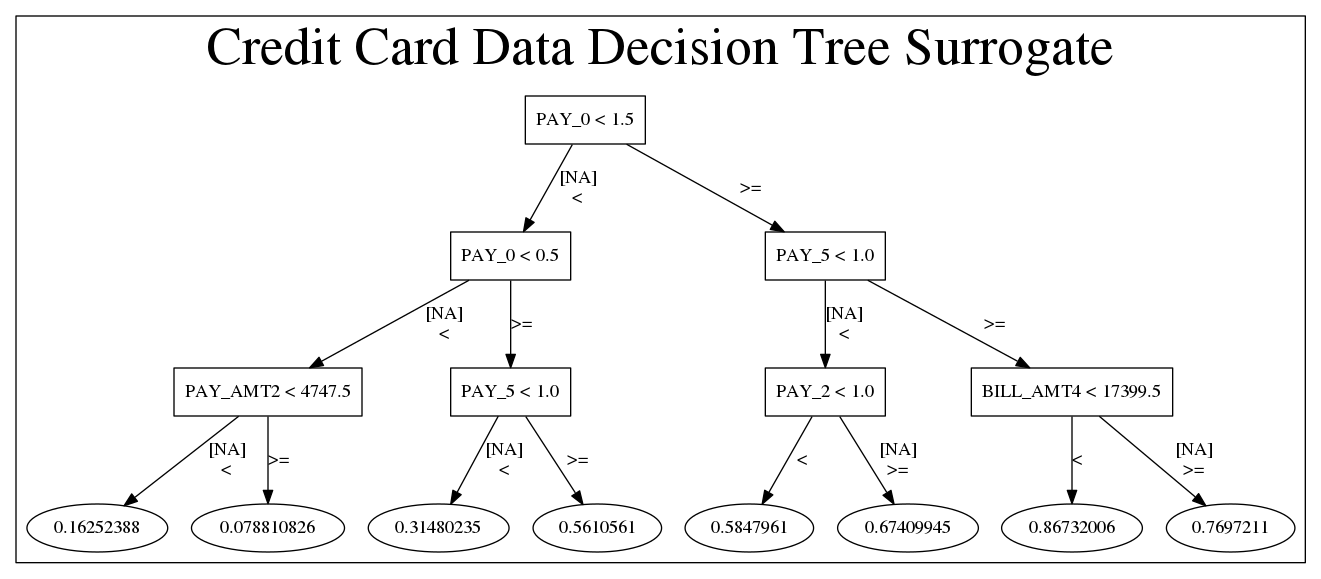

In [32]:
# display in-notebook
display(Image((png_file_name)))

# Local Explanations (variable importance) at Several Percentiles of Model Predictions

***

#### Utility function that displays the TreeInterpreter plot at the chosen decile 

In [33]:
def eli5_dd(decile):
    row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]
    eli5_df = eli5.explain_prediction_df(xgb_model, row[X].iloc[0]).sort_values(by='weight', ascending=True)
    _ = eli5_df[['feature', 'weight']].plot(kind='bar', title='Approximate Local Contributions', x='feature', legend=False)
    return eli5.explain_prediction_xgboost(xgb_model, row[X].iloc[0])

#### Utility function that displays the LIME result at the choosen decile

In [34]:
# learn what to discretize from var imp 
explainer = LIMEExplainer(training_frame=test, X=X, model=xgb_model, discretize=['PAY_0', 'PAY_2', 'PAY_3'])

def lime(decile):
    row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]
    explainer.explain(row.index[0]) 

#### Utility function that displays the Shapley results at the choosen decile

In [35]:
def shapley(row):
    s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(23, 1), columns=['Approximate Local Contributions'], index=X)
    s_df = s_df.sort_values(by='Approximate Local Contributions')
    print(s_df, '\n')
    _= s_df.plot(kind='bar', title='Approximate Local Contributions', legend=False)
    print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
    p = row['predict'].values[0]
    print('Model prediction: ', np.log(p/(1 - p)))

##  10th decile of model predictions

In [36]:
decile = 10
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

### Shapley values

           Approximate Local Contributions
PAY_0                            -0.468699
LIMIT_BAL                        -0.330274
PAY_AMT1                         -0.233416
PAY_AMT2                         -0.212458
PAY_AMT3                         -0.142837
BILL_AMT1                        -0.130155
SEX                              -0.058942
BILL_AMT2                        -0.036197
PAY_AMT6                         -0.035014
PAY_AMT4                         -0.033662
BILL_AMT5                        -0.033618
PAY_6                            -0.017624
PAY_AMT5                         -0.015722
BILL_AMT4                        -0.014277
PAY_2                            -0.011703
BILL_AMT3                        -0.010269
BILL_AMT6                        -0.008971
PAY_5                            -0.006559
PAY_4                            -0.001232
EDUCATION                         0.016901
PAY_3                             0.059656
MARRIAGE                          0.083817
AGE        

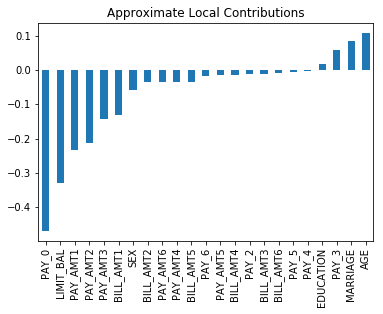

In [37]:
shapley(row)

### TreeInterpreter

Explanation(estimator='<xgboost.core.Booster object at 0x7fd7aa8a15f8>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='AGE', weight=0.14126849841960812, std=None, value=41.0), FeatureWeight(feature='MARRIAGE', weight=0.06539793366754618, std=None, value=1.0), FeatureWeight(feature='PAY_3', weight=0.026206034447656873, std=None, value=0.0), FeatureWeight(feature='EDUCATION', weight=0.019615447374296886, std=None, value=2.0), FeatureWeight(feature='PAY_6', weight=0.0009519221428973654, std=None, value=0.0)], neg=[FeatureWeight(feature='LIMIT_BAL', weight=-0.48051545533996964, std=None, value=420000.0), FeatureWeight(feature='PAY_0', weight=-0.41896827829939426, std=None, value=0.0), FeatureWeight(feature='PAY_AMT1', weight=-0.20606679066954842, std=None, value=33808.0), FeatureWeight(feature='PAY_AMT2', weight=-0.16214814545459302, std=None, value=14996.0), FeatureWeight(feature='PAY_AMT3', weight=-0.14274467107635624, std=None, value=13209.0), FeatureWeight(feature='BILL_AMT1', weight=-0.10265594720385038, std=None, value=373978.0), FeatureWeight(feature='BILL_AMT2', weight=-0.06254677698049986, std=None, value=389754.0), FeatureWeight(feature='SEX', weight=-0.06190215347382486, std=None, value=2.0), FeatureWeight(feature='PAY_2', weight=-0.02651960647802904, std=None, value=0.0), FeatureWeight(feature='BILL_AMT5', weight=-0.02582535260384361, std=None, value=354813.0), FeatureWeight(feature='PAY_AMT6', weight=-0.020497349434992443, std=None, value=16298.0), FeatureWeight(feature='PAY_AMT4', weight=-0.016744690616057524, std=None, value=12890.0), FeatureWeight(feature='PAY_5', weight=-0.014575998477968078, std=None, value=0.0), FeatureWeight(feature='BILL_AMT4', weight=-0.011677110037661899, std=None, value=361024.0), FeatureWeight(feature='PAY_AMT5', weight=-0.010914854880041326, std=None, value=11081.0), FeatureWeight(feature='PAY_4', weight=-0.01063990868641441, std=None, value=0.0), FeatureWeight(feature='<BIAS>', weight=-0.009734693712719808, std=None, value=1.0), FeatureWeight(feature='BILL_AMT3', weight=-0.009076024260820633, std=None, value=366938.0), FeatureWeight(feature='BILL_AMT6', weight=-0.0024111205654204315, std=None, value=344221.0)], pos_remaining=0, neg_remaining=0), proba=None, score=-1.5427250922000013, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

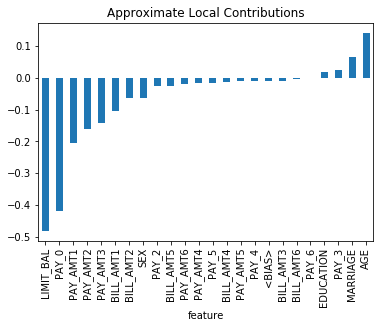

In [38]:
eli5_dd(decile)

In [39]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  -2.796777692533134


### LIME


Model Prediction: 0.06
Local GLM Prediction: 0.03
Local GLM R-square: 0.71
Local GLM Intercept: -0.26

Approximate Local Contributions:
                     Input  Local Contribution
0   PAY_0.(-0.0119, 0.751]           -0.044778
1   PAY_2.(-0.0128, 0.808]           -0.032659
2   PAY_3.(-0.0128, 0.807]           -0.025613
3                 PAY_AMT6            0.001472
4                 PAY_AMT5            0.001708
5                 PAY_AMT3            0.001753
6                 PAY_AMT4            0.001831
7                 PAY_AMT2            0.001892
8                 MARRIAGE            0.004865
9                 PAY_AMT1            0.005632
10               EDUCATION            0.011683
11                     AGE            0.014095
12               BILL_AMT6            0.018224
13               BILL_AMT3            0.018642
14               BILL_AMT1            0.018645
15               BILL_AMT4            0.019066
16               BILL_AMT5            0.019083
17               

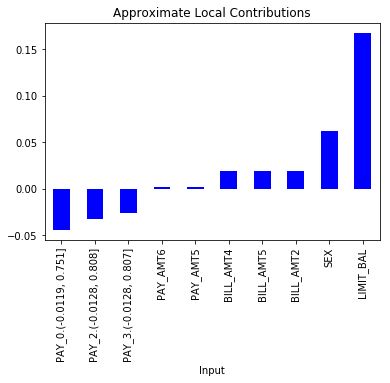

In [40]:
lime(decile)

##  Median of predictions

In [41]:
decile = 50
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

### Shapley values

           Approximate Local Contributions
PAY_0                            -0.411915
BILL_AMT1                        -0.125210
SEX                              -0.061932
PAY_AMT2                         -0.042522
PAY_6                            -0.041212
PAY_AMT1                         -0.035968
PAY_2                            -0.034426
BILL_AMT5                        -0.028345
PAY_5                            -0.024211
PAY_AMT6                         -0.016077
PAY_AMT4                         -0.014974
BILL_AMT2                        -0.013526
PAY_4                            -0.011672
BILL_AMT3                        -0.009626
PAY_AMT5                         -0.009130
BILL_AMT6                        -0.008353
BILL_AMT4                        -0.004733
PAY_AMT3                         -0.002004
PAY_3                             0.010511
EDUCATION                         0.013597
MARRIAGE                          0.064320
AGE                               0.129554
LIMIT_BAL  

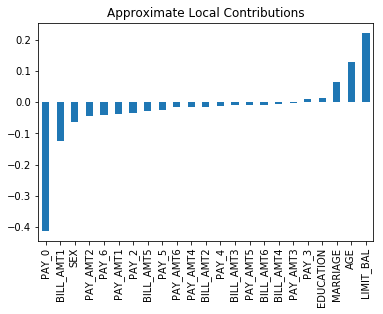

In [42]:
shapley(row)

### TreeInterpreter 

Explanation(estimator='<xgboost.core.Booster object at 0x7fd7aa8a15f8>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='LIMIT_BAL', weight=0.3169238969675609, std=None, value=50000.0), FeatureWeight(feature='MARRIAGE', weight=0.06969734026488657, std=None, value=1.0), FeatureWeight(feature='AGE', weight=0.058888429496241165, std=None, value=61.0), FeatureWeight(feature='EDUCATION', weight=0.02176956749995677, std=None, value=2.0), FeatureWeight(feature='PAY_3', weight=0.005653859226067826, std=None, value=0.0), FeatureWeight(feature='PAY_AMT3', weight=0.0009899483890423225, std=None, value=975.0)], neg=[FeatureWeight(feature='PAY_0', weight=-0.42410143888051804, std=None, value=0.0), FeatureWeight(feature='BILL_AMT1', weight=-0.11940511720034033, std=None, value=47166.0), FeatureWeight(feature='PAY_AMT2', weight=-0.07445132815270457, std=None, value=2237.0), FeatureWeight(feature='SEX', weight=-0.0607602903684865, std=None, value=2.0), FeatureWeight(feature='PAY_AMT1', weight=-0.04857168933700309, std=None, value=3000.0), FeatureWeight(feature='PAY_2', weight=-0.046187118395056716, std=None, value=0.0), FeatureWeight(feature='PAY_6', weight=-0.030875118159245138, std=None, value=0.0), FeatureWeight(feature='PAY_AMT6', weight=-0.028560399966908755, std=None, value=1039.0), FeatureWeight(feature='BILL_AMT5', weight=-0.022016795090588792, std=None, value=23171.0), FeatureWeight(feature='PAY_4', weight=-0.016004675246565722, std=None, value=0.0), FeatureWeight(feature='PAY_AMT5', weight=-0.014491867534213564, std=None, value=2000.0), FeatureWeight(feature='PAY_5', weight=-0.013912554260662426, std=None, value=0.0), FeatureWeight(feature='PAY_AMT4', weight=-0.012168227600849787, std=None, value=1000.0), FeatureWeight(feature='<BIAS>', weight=-0.009734693712719808, std=None, value=1.0), FeatureWeight(feature='BILL_AMT6', weight=-0.005891945467181839, std=None, value=24774.0), FeatureWeight(feature='BILL_AMT2', weight=-0.005074694449399835, std=None, value=49396.0), FeatureWeight(feature='BILL_AMT3', weight=-0.004137887068251654, std=None, value=50476.0), FeatureWeight(feature='BILL_AMT4', weight=-0.00277721959805933, std=None, value=23319.0)], pos_remaining=0, neg_remaining=0), proba=None, score=-0.465200018645, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

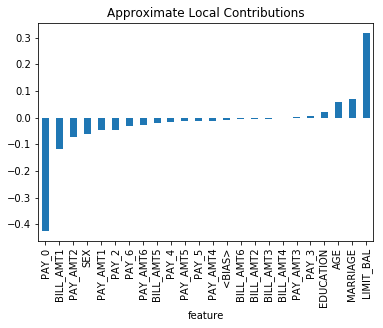

In [43]:
eli5_dd(decile)

In [44]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  -1.7192525431094163


### LIME


Model Prediction: 0.15
Local GLM Prediction: 0.15
Local GLM R-square: 0.84
Local GLM Intercept: 0.38

Approximate Local Contributions:
                    Input  Local Contribution
0  PAY_0.(-0.0119, 0.751]       -1.015262e-01
1  PAY_2.(-0.0128, 0.808]       -8.407705e-02
2  PAY_3.(-0.0128, 0.807]       -7.819486e-02
3                PAY_AMT2       -9.823950e-07
4               EDUCATION        2.664151e-04
5                     SEX        1.762975e-02
6               LIMIT_BAL        1.863846e-02
None


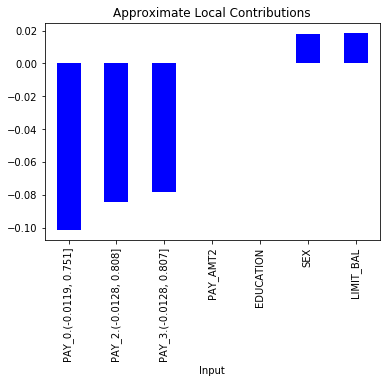

In [45]:
lime(decile)

##  90th decile of model predictions

In [46]:
decile = 90
row = decile_frame[decile_frame['ID'] == percentile_dict[decile]]

### Shapley values

           Approximate Local Contributions
BILL_AMT1                        -0.110589
AGE                              -0.096471
MARRIAGE                         -0.080873
PAY_AMT2                         -0.064753
PAY_6                            -0.052491
BILL_AMT5                        -0.042470
SEX                              -0.026670
PAY_AMT4                         -0.022627
PAY_AMT1                         -0.014891
BILL_AMT2                        -0.014388
PAY_5                            -0.010738
BILL_AMT3                        -0.010732
BILL_AMT6                        -0.010083
BILL_AMT4                        -0.009537
PAY_AMT5                         -0.004466
PAY_2                             0.003455
EDUCATION                         0.008958
PAY_AMT6                          0.037310
PAY_3                             0.055879
LIMIT_BAL                         0.057011
PAY_AMT3                          0.111882
PAY_4                             0.207193
PAY_0      

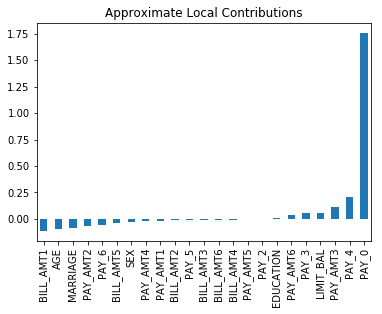

In [47]:
shapley(row)

### TreeInterpreter

Explanation(estimator='<xgboost.core.Booster object at 0x7fd7aa8a15f8>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='PAY_0', weight=1.840726509829763, std=None, value=2.0), FeatureWeight(feature='PAY_4', weight=0.18719219868262635, std=None, value=2.0), FeatureWeight(feature='PAY_AMT3', weight=0.05341854983227486, std=None, value=0.0), FeatureWeight(feature='PAY_3', weight=0.0515922103597632, std=None, value=0.0), FeatureWeight(feature='PAY_AMT6', weight=0.049103624004179704, std=None, value=0.0), FeatureWeight(feature='LIMIT_BAL', weight=0.023397968099060903, std=None, value=90000.0), FeatureWeight(feature='PAY_AMT1', weight=0.022450945999154176, std=None, value=4100.0), FeatureWeight(feature='PAY_AMT5', weight=0.007475938752441164, std=None, value=7200.0), FeatureWeight(feature='PAY_2', weight=0.005543738780018485, std=None, value=0.0), FeatureWeight(feature='EDUCATION', weight=0.00015983964801691652, std=None, value=2.0)], neg=[FeatureWeight(feature='MARRIAGE', weight=-0.11587752486068419, std=None, value=2.0), FeatureWeight(feature='BILL_AMT1', weight=-0.09333710452252324, std=None, value=89346.0), FeatureWeight(feature='PAY_6', weight=-0.09039780397121719, std=None, value=0.0), FeatureWeight(feature='BILL_AMT5', weight=-0.07901963408884112, std=None, value=89221.0), FeatureWeight(feature='PAY_5', weight=-0.048724529562618954, std=None, value=0.0), FeatureWeight(feature='AGE', weight=-0.04720519476108612, std=None, value=24.0), FeatureWeight(feature='PAY_AMT2', weight=-0.030666494395657003, std=None, value=8245.0), FeatureWeight(feature='PAY_AMT4', weight=-0.022871399868175546, std=None, value=3450.0), FeatureWeight(feature='SEX', weight=-0.014222511799670436, std=None, value=2.0), FeatureWeight(feature='BILL_AMT3', weight=-0.010712855037480866, std=None, value=93755.0), FeatureWeight(feature='BILL_AMT6', weight=-0.009735289775551626, std=None, value=91596.0), FeatureWeight(feature='<BIAS>', weight=-0.009734693712719808, std=None, value=1.0), FeatureWeight(feature='BILL_AMT2', weight=-0.009728250070278766, std=None, value=89466.0), FeatureWeight(feature='BILL_AMT4', weight=-0.002261120060793781, std=None, value=89706.0)], pos_remaining=0, neg_remaining=0), proba=None, score=1.6565671174999996, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

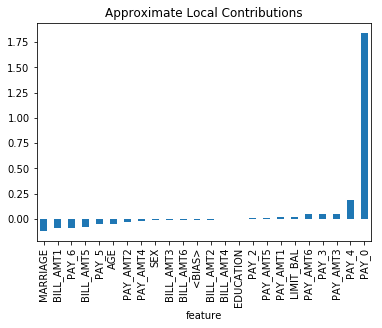

In [48]:
eli5_dd(decile)

In [49]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  0.40251465275609066


### LIME


Model Prediction: 0.60
Local GLM Prediction: 0.58
Local GLM R-square: 0.22
Local GLM Intercept: 0.79

Approximate Local Contributions:
                     Input  Local Contribution
0                      SEX       -1.479479e-01
1                LIMIT_BAL       -7.607107e-02
2                EDUCATION       -4.017808e-02
3                 MARRIAGE       -2.646786e-02
4                      AGE       -5.461645e-03
5                    PAY_4       -1.474736e-03
6                BILL_AMT1       -2.015915e-16
7                BILL_AMT6       -5.150921e-18
8                BILL_AMT5       -4.890850e-18
9                 PAY_AMT2       -2.492660e-18
10  PAY_3.(-0.0128, 0.807]        2.162996e-02
11  PAY_2.(-0.0128, 0.808]        2.945958e-02
12    PAY_0.(1.988, 2.751]        4.541000e-02
None


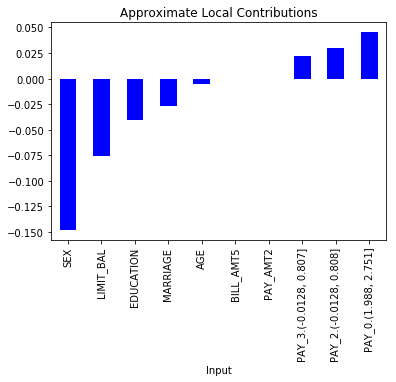

In [50]:
lime(decile)